In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix
from matplotlib.lines import Line2D

In [2]:
from sklearn import cluster, metrics
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from itertools import combinations_with_replacement


In [3]:
import sys 
sys.path.append("../")
from functions.run_ica import *

In [4]:
# Data was filtered to preserve one sample type per experimental condition 
data = pd.read_csv("../data/filtered_data.csv",index_col=0)

In [5]:
# Non-standard normalization in order to preserve sparsity, as z-scores fail to execute
# due to mathematical error of dividing by zero
scaler = StandardScaler(with_mean=False)
scaler.fit(data.transpose())
norm_data = scaler.transform(data.transpose())

In [9]:
M,A = run_ica(norm_data[0:20], n_comp=20)

Running iteration: 0
0.9999999974625452
0.999999999896636
0.9999999999470276
0.9999999999456999
0.9999999999907365
0.999999994989406
0.999999999969976
0.9999999999770959
0.9999999144006845
0.9999999204257322
0.9999999999982533
0.9999999997914233
0.999999826787184
0.9999999998630411
0.9999999997260772
0.9999999994848154
0.9999998267840378
0.9999999999100463
0.9999999995875861
0.9999999998169359
Running iteration: 1
0.70710682747404
0.7071075035841623
0.7071126457351588
0.7071066047609746
0.7071067779510627
0.7071117725922438
0.70710670937753
0.7071068631484774
0.7071089177541924
0.7071067262258048
0.7071068360283207
0.7071124680433445
0.7071068277102358
0.7071074102681991
0.7071076009237914
0.7071068812977721
0.7071068196810713
0.7071084845433432
0.7071068494418703
0.7071066808566018
Running iteration: 2
0.8164965471255243
0.8164777421270113
0.816496564503795
0.8164856016575607
0.816496295127109
0.8164966987348105
0.8164959247121503
0.816496762644445
0.8164939754388749
0.816499098629939

In [10]:
M

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000354,-0.000030,0.006528,-0.000716,0.000243,-0.000515,0.000098,-0.000681,-0.000330,0.006204,-0.000237,-0.000650,-0.000609,-0.000499,-0.000562,-0.000747,-0.000524,0.012376,0.025765,0.000333
1,0.000089,0.000043,0.000003,-0.000383,0.000107,-0.000252,0.000058,-0.000387,-0.000307,-0.000279,-0.000327,-0.000351,-0.000237,-0.000295,-0.000413,-0.000344,-0.000417,-0.000390,-0.000290,0.000015
2,0.000160,0.001424,0.000002,-0.000404,-0.002635,-0.000297,0.000062,-0.000395,-0.000314,-0.000290,-0.000325,-0.000462,-0.000245,-0.000336,-0.000443,-0.000364,-0.000456,0.000258,-0.000375,0.000672
3,0.000089,0.000043,0.000003,-0.000383,0.000107,-0.000252,0.000058,-0.000387,-0.000307,-0.000279,-0.000327,-0.000351,-0.000237,-0.000295,-0.000413,-0.000344,-0.000417,-0.000390,-0.000290,0.000015
4,0.000089,0.000043,0.000003,-0.000383,0.000107,-0.000252,0.000058,-0.000387,-0.000307,-0.000279,-0.000327,-0.000351,-0.000237,-0.000295,-0.000413,-0.000344,-0.000417,-0.000390,-0.000290,0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31517,0.000089,0.000043,0.000003,-0.000383,0.000107,-0.000252,0.000058,-0.000387,-0.000307,-0.000279,-0.000327,-0.000351,-0.000237,-0.000295,-0.000413,-0.000344,-0.000417,-0.000390,-0.000290,0.000015
31518,0.000187,0.000016,0.002425,-0.000507,0.000157,-0.000350,0.000073,-0.000496,-0.000315,0.002128,-0.000293,-0.000462,-0.000375,-0.000371,-0.000469,-0.000494,-0.000457,0.004349,0.009382,0.000133
31519,0.000089,0.000043,0.000003,-0.000383,0.000107,-0.000252,0.000058,-0.000387,-0.000307,-0.000279,-0.000327,-0.000351,-0.000237,-0.000295,-0.000413,-0.000344,-0.000417,-0.000390,-0.000290,0.000015
31520,0.000134,0.000069,0.000027,0.009828,0.000029,-0.000517,0.000128,0.004651,0.004805,0.009893,-0.000316,-0.003655,0.002147,-0.000439,-0.000596,-0.000458,-0.000442,0.002051,-0.003377,-0.000188


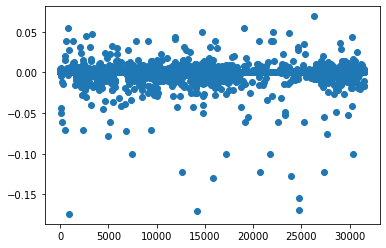

In [12]:
fig,ax = plt.subplots()
ax.plot(list(M.index),M[0],"o")

In [12]:
from sklearn.decomposition import FastICA
ica_transformer_1 = FastICA(n_components=30,random_state=0).fit(norm_data[0:300].transpose())
M1 = pd.DataFrame(ica_transformer_1.transform(norm_data[0:300].transpose()))
ica_transformer_2 = FastICA(n_components=30,random_state=1).fit(norm_data[0:300].transpose())
M2 = pd.DataFrame(ica_transformer_2.transform(norm_data[0:300].transpose()))

In [13]:
A1 = pd.DataFrame(ica_transformer_1.mixing_)
A2 = pd.DataFrame(ica_transformer_2.mixing_)

In [14]:
A1.reindex(columns=range(len(A1.columns)))

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.102851,-0.135568,-0.362526,-0.206713,-5.175461,3.698771,-3.457578,0.436994,-0.784585,-0.075767,...,1.518470,0.022358,-5.923170,-0.861245,0.343612,1.378975,0.416105,0.570681,0.538860,-0.603046
1,0.532319,-0.401332,-0.267678,-0.324219,0.275862,2.813886,-0.960526,-1.503000,0.345004,-0.494619,...,0.827427,-0.829515,0.607342,0.178193,-2.735878,1.574790,0.259083,-0.192381,0.592388,-334.732100
2,0.719260,-0.063816,0.136733,0.496026,6.264853,1.386231,0.630185,-3.114027,1.107545,-1.451012,...,1.609799,-1.389759,4.481362,0.117363,-5.829440,1.026282,1.300361,-0.029081,-0.564992,-0.822633
3,1.353137,-1.499432,-0.192706,1.079097,4.496191,3.131673,-2.583370,-1.166425,0.645099,-0.042078,...,2.451100,-4.897603,5.868671,1.364349,-5.124493,1.547768,3.754450,-0.420292,1.701511,-2.566660
4,-0.064136,-0.728284,-0.588772,2.243621,0.898927,0.292039,-0.702866,-0.934779,-1.566747,-1.137498,...,0.957969,-2.140266,5.566207,0.730299,-2.823582,0.645445,2.818772,1.277397,1.275147,-7.853396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2.003539,-0.591462,0.481936,0.431935,2.926714,1.470612,-1.237476,-2.022823,-2.278118,1.477271,...,0.549169,-5.271060,6.041089,2.552972,-12.463706,0.258908,2.636667,0.412012,1.939042,-0.006028
296,2.255845,-0.091589,1.400618,1.523412,3.532671,1.538871,-1.654932,-1.655181,-1.125908,1.007382,...,0.748136,-4.318223,2.340502,1.614187,-11.425667,-0.004163,3.048750,1.416111,0.257790,-0.167936
297,1.991770,-0.442536,1.305170,2.104647,3.071718,1.991205,-0.343082,-0.654182,-3.519359,0.355210,...,1.092557,-3.573901,3.219761,2.463887,-11.461608,0.275065,0.753468,1.083252,-0.070759,0.353235
298,1.332100,-0.953881,5.523860,0.415658,6.263912,2.393721,-1.890481,-0.886774,-3.924620,1.056737,...,-0.333302,-6.047985,1.179744,1.579726,-15.062192,0.135483,0.888420,0.252156,1.268914,-0.103355


In [119]:
metrics = pd.DataFrame(index = range(0,len(M1.columns)),columns= range(0,len(M1.columns)))
for i in range(0,len(M1.columns)):
    for j in range(0,len(M2.columns)):
        metrics.loc[i][j] = abs(pearsonr(M1[i],M2[j])[0])
metrics= metrics.fillna(0)
metrics

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.001517,0.000015,1.777592e-06,0.000284,0.000647,1.226986e-05,0.000032,8.325481e-06,1.296754e-05,1.123485e-06,...,1.683908e-05,0.002222,1.605653e-05,3.161690e-06,2.556481e-05,1.746644e-05,2.842871e-06,1.717375e-05,4.079571e-06,1.092268e-05
1,0.709877,0.001626,4.988472e-05,0.001141,0.007204,7.103182e-05,0.000446,3.439839e-04,1.124067e-03,4.921018e-05,...,6.259373e-05,0.704280,1.141631e-04,8.250088e-05,1.098404e-03,6.950198e-04,2.515998e-04,1.044273e-03,4.482965e-04,4.973062e-04
2,0.000524,0.000042,2.609923e-05,0.000290,0.004680,3.427897e-05,0.000161,1.494133e-05,9.999866e-01,6.402189e-06,...,2.431163e-05,0.002076,7.452468e-07,1.807399e-05,6.116171e-06,2.535779e-05,5.401559e-07,4.404386e-05,2.722998e-05,4.869993e-05
3,0.000663,0.000116,4.475600e-06,0.003291,0.001554,5.331633e-05,0.000149,3.174527e-06,3.377321e-05,1.869157e-06,...,1.638677e-05,0.000339,5.732689e-06,5.192743e-06,1.137318e-06,9.999921e-01,1.789877e-06,3.205783e-06,6.631051e-06,1.085812e-05
4,0.001238,0.000616,1.597105e-04,0.248728,0.051639,9.841859e-04,0.009422,2.286653e-05,6.014719e-05,6.336708e-05,...,3.996816e-04,0.002825,3.276433e-04,2.052841e-04,7.785335e-04,4.349436e-04,8.459015e-05,1.868172e-04,1.852782e-04,2.515027e-04
5,0.000487,0.000037,1.334915e-07,0.000361,0.000778,2.927574e-06,0.000108,6.459198e-06,5.262088e-06,8.413267e-07,...,8.677264e-06,0.001129,8.305994e-06,1.347544e-06,5.083602e-06,2.602169e-06,3.776127e-06,8.897892e-07,2.596091e-06,1.136891e-06
6,0.000166,0.000069,1.125539e-05,0.002374,0.001955,5.634875e-07,0.000412,7.214336e-06,1.847727e-05,7.805823e-06,...,2.098937e-06,0.000767,1.804572e-05,4.306573e-06,1.544345e-05,2.508743e-05,2.612726e-06,3.788546e-06,1.962448e-05,1.597489e-05
7,0.000396,0.000033,9.892056e-06,0.000669,0.000415,1.403956e-05,0.000042,9.999996e-01,1.665270e-05,1.938384e-06,...,9.601751e-06,0.000093,2.600379e-06,3.752511e-07,2.092305e-05,1.665554e-06,9.271623e-07,1.424907e-05,2.798808e-06,9.474902e-07
8,0.001202,0.000053,2.035418e-05,0.007143,0.003296,4.491249e-05,0.000196,1.438931e-05,2.551866e-05,8.410316e-06,...,9.348271e-07,0.002748,5.760210e-06,9.331635e-06,9.999641e-01,2.084038e-05,4.050120e-06,2.562443e-05,2.245570e-05,5.693282e-06
9,0.001285,0.000004,8.184562e-06,0.001743,0.002584,6.805686e-05,0.000012,1.635720e-06,3.234135e-05,1.013647e-06,...,2.747972e-06,0.001978,4.366060e-06,1.875265e-07,3.371681e-05,9.221767e-06,4.559866e-06,1.241793e-05,6.088085e-06,9.999923e-01


In [121]:
M = pd.DataFrame(index=M1.index)
for i,item in metrics.iteritems():
    for j in item.index:
        if item[j] == max(item) and abs(max(item)) > .9:
            M1_abs_max = float(M1[i].loc[M1[i].abs().nlargest(1).index])
            M2_abs_max = float(M2[j].loc[M2[j].abs().nlargest(1).index])
            A1_abs_max = float(A1[i].loc[A1[i].abs().nlargest(1).index])
            A2_abs_max = float(A2[j].loc[A2[j].abs().nlargest(1).index])
            if M1_abs_max < 0:
                M1_corrected = -M1[i]
            else:
                M1_corrected = M1[i]
            if M2_abs_max < 0:
                M2_corrected = -M2[i]
            else:
                M2_corrected = M2[i]
            if A1_abs_max < 0:
                A1_corrected = -A1[i]
            else:
                A1_corrected = A1[i]
            if A2_abs_max < 0:
                A2_corrected = -A2[i]
            else:
                A2_corrected = A2[i]
            M[str(i)+"_"+str(j)] = (M1_corrected+M2_corrected)/2 
            A[str(i)+"_"+str(j)] = (A1_corrected+M2_corrected)/2 

In [122]:
M

,1_10,2_26,4_24,5_12,6_16,7_7,8_2,9_29,10_22,11_15,...,19_18,20_23,22_19,23_28,24_8,25_3,26_25,27_14,28_17,29_9
0,0.000639,-0.000061,-0.002092,-0.002191,0.021372,-0.001640,0.000078,0.009648,-0.000070,-0.000208,...,-0.022966,-0.001671,0.000799,0.000466,-0.003275,0.000693,-0.001564,-0.001128,-0.000275,0.009643
1,0.000058,0.000472,0.000196,-0.000340,0.000134,-0.000949,0.000177,-0.001132,-0.009557,-0.000150,...,-0.000370,-0.000887,0.009908,-0.000109,-0.000125,-0.000561,-0.001796,-0.001022,-0.000204,-0.001129
2,0.002144,0.000445,0.000326,-0.001264,0.001770,-0.000880,-0.000144,0.001326,-0.001654,0.002019,...,-0.000456,-0.001011,0.000968,0.000180,0.001936,0.000279,-0.001582,0.001254,0.000223,0.001330
3,0.000493,0.000054,-0.000048,-0.000250,-0.000230,-0.000689,0.000453,-0.000650,0.000239,0.000319,...,-0.000459,-0.000827,0.000315,-0.000035,-0.000078,-0.000216,-0.000984,-0.000757,-0.000514,-0.000650
4,0.000100,0.000303,-0.001487,-0.000053,-0.000081,-0.000531,-0.000055,-0.000385,0.000287,0.000072,...,-0.000088,-0.000478,-0.000181,-0.000078,-0.001397,-0.000152,-0.000774,-0.000673,-0.000051,-0.000388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31517,0.000100,0.000303,-0.001487,-0.000053,-0.000081,-0.000531,-0.000055,-0.000385,0.000287,0.000072,...,-0.000088,-0.000478,-0.000181,-0.000078,-0.001397,-0.000152,-0.000774,-0.000673,-0.000051,-0.000388
31518,-0.011734,0.007106,0.000427,-0.001145,0.000529,-0.001086,-0.006440,-0.001755,-0.000160,0.003295,...,0.000370,0.005773,0.008572,0.007388,-0.000280,-0.000003,-0.002079,-0.001831,0.000036,-0.001758
31519,0.000865,0.000377,-0.000863,0.000006,0.000099,-0.000907,0.000067,-0.000950,-0.000155,-0.000186,...,0.000628,-0.000667,-0.000429,-0.000054,-0.001186,0.000064,-0.001403,0.027724,-0.000319,-0.000950
31520,-0.005513,0.002994,0.002764,-0.000330,0.015585,-0.000752,-0.005973,-0.002076,0.006681,-0.000722,...,0.000070,-0.001267,-0.000092,0.000050,0.001009,0.000839,0.001181,-0.002061,0.000677,-0.002064


In [125]:
A

,0,1,2,3,4,5,6,7,8,9,...,13_4,15_5,18_6,19_18,22_19,24_8,25_3,26_25,27_14,28_17
0,0.102851,-0.135568,-0.362526,-0.206713,-5.175461,3.698771,-3.457578,0.436994,-0.784585,-0.075767,...,-0.211957,0.232035,0.907721,2.051523,-2.960234,-0.172649,0.690903,0.207331,0.284835,0.270197
1,0.532319,-0.401332,-0.267678,-0.324219,0.275862,2.813886,-0.960526,-1.503000,0.345004,-0.494619,...,-0.026656,-0.088072,0.187407,0.313212,0.303958,1.367448,0.787483,0.128892,-0.097193,0.296258
2,0.719260,-0.063816,0.136733,0.496026,6.264853,1.386231,0.630185,-3.114027,1.107545,-1.451012,...,0.949694,-0.448383,-0.091405,3.202614,2.241473,2.914002,0.513966,0.649635,-0.015239,-0.281985
3,1.353137,-1.499432,-0.192706,1.079097,4.496191,3.131673,-2.583370,-1.166425,0.645099,-0.042078,...,0.652611,0.425400,-0.587056,2.123968,2.934933,2.562134,0.774034,1.876859,-0.210831,0.850591
4,-0.064136,-0.728284,-0.588772,2.243621,0.898927,0.292039,-0.702866,-0.934779,-1.566747,-1.137498,...,1.055764,0.386000,-0.399362,1.742529,2.783329,1.411566,0.322881,1.409076,0.638181,0.637690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2.003539,-0.591462,0.481936,0.431935,2.926714,1.470612,-1.237476,-2.022823,-2.278118,1.477271,...,1.093416,0.620715,-0.199075,1.405316,3.020770,6.231628,0.129612,1.318024,0.205489,0.969638
296,2.255845,-0.091589,1.400618,1.523412,3.532671,1.538871,-1.654932,-1.655181,-1.125908,1.007382,...,1.631828,0.314066,-0.103101,1.474860,1.169725,5.711722,-0.002829,1.525113,0.707261,0.129723
297,1.991770,-0.442536,1.305170,2.104647,3.071718,1.991205,-0.343082,-0.654182,-3.519359,0.355210,...,1.368479,0.004965,0.247979,0.555475,1.610106,5.730579,0.137691,0.376424,0.541108,-0.035262
298,1.332100,-0.953881,5.523860,0.415658,6.263912,2.393721,-1.890481,-0.886774,-3.924620,1.056737,...,0.839948,0.242695,0.428091,0.703684,0.590097,7.530871,0.067899,0.443900,0.125560,0.634574
